In [1]:
import os
os.environ["MODIN_ENGINE"] = "dask"  # Modin will use Dask

In [2]:
import xarray as xr
import numpy as np
import modin.pandas as pd
import dask.dataframe as dd
from copy import deepcopy
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster
import dask
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import glob
from os.path import join
import glob

In [10]:
def convert_to_xarray(tracks):
    """
    Output metadata from generated tornado tracks and population exposure as gridded Xarray dataset.
    Args:
        tracks (GeoDataFrame): Generated tornado trakc and associated metadata.

    Returns: Xarray Dataset of gridded population exposures.

    """

    ds_3D = tracks.set_index('track').groupby(['valid_time', 'x', 'y']).apply(
        lambda x: x.loc[0, ['lat', 'lon']]).to_xarray()
    ds_4D = tracks.set_index(['valid_time', 'y', 'x', 'track'])[
        ['total_pop', 'exposure', 'exposure_percent']].to_xarray()
    ds = xr.merge([ds_3D, ds_4D])

    return ds

In [3]:
cluster = PBSCluster(resource_spec='select=1:ncpus=18:mem=32GB',
                     project='NAML0001',
                     # cores=2,
                     n_workers=8,
                     queue='casper',
                     walltime='01:00:00',
                     memory="32GB",
                     interface='ib0',
                     local_directory='/glade/work/cbecker/conv_risk_intel/dask/',
                     log_directory="/glade/work/cbecker/conv_risk_intel/dask_logs/")

# Change your url to the dask dashboard so you can see it
# dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})
print(f"Use this link to monitor the workload: {cluster.dashboard_link}")
                    
client = Client(cluster)
# cluster

Use this link to monitor the workload: https://jupyterhub.hpc.ucar.edu/stable/user/cbecker/proxy/8787/status


In [5]:
# client.shutdown()

In [7]:
%%time
for m in range(3, 11):
    print(m)
    base_path = f"/glade/scratch/cbecker/crisis_ens_output_tracks_20230322_20km/member_{m}/tracks/"
    files = glob.glob(join(base_path, "GAN_tornado_tracks_x*"))
    tracks = dd.read_parquet(files, columns=["track", "valid_time", "lat", "lon", "x", "y", "dx", "dy", "width", "total_pop", "exposure", "exposure_percent"]).persist()
    valid_times = tracks['valid_time'].unique().compute()
    for vt in valid_times:
        datetime = pd.to_datetime(vt).strftime("%Y%m%d_%H00")
        # tracks[tracks['valid_time'] == vt].to_parquet(join(base_path, f"GAN_tornado_tracks_{datetime}.parquet"))
        vt_tracks = tracks[tracks['valid_time'] == vt].repartition(npartitions=1).compute()
        vt_tracks.to_parquet(join(base_path, f"GAN_tornado_tracks_{datetime}.parquet"))
    del tracks, files, base_path, valid_times, vt_tracks

3
4
5
6
7
8
9
10
CPU times: user 19min, sys: 5min 30s, total: 24min 31s
Wall time: 40min 56s


In [19]:
del ddf

In [20]:
ddf = dd.read_parquet('/glade/scratch/cbecker/crisis_ens_output_tracks_20230322_20km/member_1/tracks/GAN_tornado_tracks_2*').compute()

In [17]:
# client.shutdown()

In [22]:
%%time
ds = convert_to_xarray(ddf)#.persist()

CPU times: user 7min 13s, sys: 9min 23s, total: 16min 37s
Wall time: 22min 53s


In [23]:
ds

<xarray.Dataset>
Dimensions:           (valid_time: 48, x: 36, y: 25, track: 10000)
Coordinates:
  * valid_time        (valid_time) datetime64[ns] 2016-05-10T01:00:00 ... 201...
  * x                 (x) int64 1 2 3 4 5 6 7 8 9 ... 28 29 30 31 32 33 34 35 36
  * y                 (y) int64 0 1 2 3 4 5 6 7 8 ... 16 17 18 19 20 21 22 23 24
  * track             (track) int64 0 1 2 3 4 5 ... 9995 9996 9997 9998 9999
Data variables:
    lat               (valid_time, x, y) float32 35.27 35.24 ... 39.95 39.93
    lon               (valid_time, x, y) float32 -88.49 -88.26 ... -91.04 -90.79
    total_pop         (valid_time, y, x, track) float32 1.257e+04 ... 5.504e+03
    exposure          (valid_time, y, x, track) float32 21.0 44.0 ... 0.0 8.0
    exposure_percent  (valid_time, y, x, track) float32 0.167 0.35 ... 0.1453

In [9]:
m = 8
base_path = f"/glade/scratch/cbecker/crisis_ens_test_tracks_20230406_20km/member_1/tracks/"
all_tracks_80km = dd.read_parquet(sorted(glob.glob(join(base_path, "GAN*?")))).reset_index().persist()

In [ ]:
%%time

# read in all 48 valid hours of tracks, lazily.
all_tracks = dd.read_parquet('/glade/p/cisl/aiml/conv_risk_intel/case_study_20160510/crisis_100m/tracks/GAN_tornado_tracks_*.parquet')

CPU times: user 10.4 ms, sys: 4.96 ms, total: 15.3 ms
Wall time: 20.4 ms


In [27]:
%%time
# make new column of track lengths using dx and dy
# computes in ~3s in background
all_tracks['track_length'] = np.sqrt((all_tracks['dx'] ** 2) + (all_tracks['dy'] ** 2)).persist()

CPU times: user 654 ms, sys: 445 ms, total: 1.1 s
Wall time: 4.84 s


In [10]:
all_tracks_80km['track_length'] = np.sqrt((all_tracks_80km['dx'] ** 2) + (all_tracks_80km['dy'] ** 2)).persist()

In [23]:
df = all_tracks_80km.compute()

In [24]:
import seaborn as sns

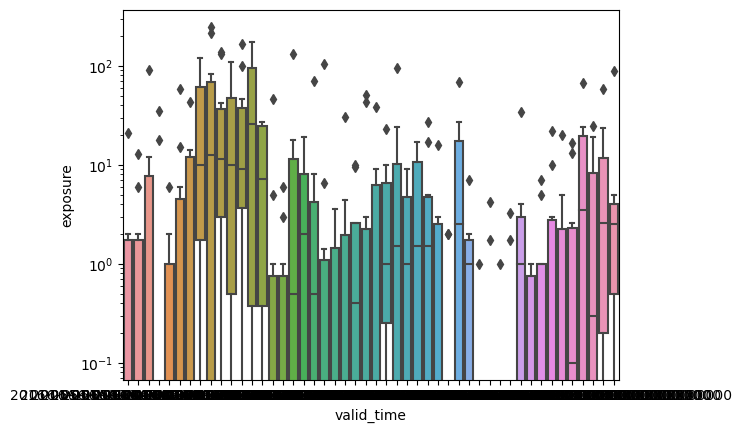

In [25]:
x, y, = 6, 6
g = sns.boxplot(data=df[(df['x'] == x) & (df['y'] == y)], x='valid_time', y='exposure')
g.set_yscale("log")

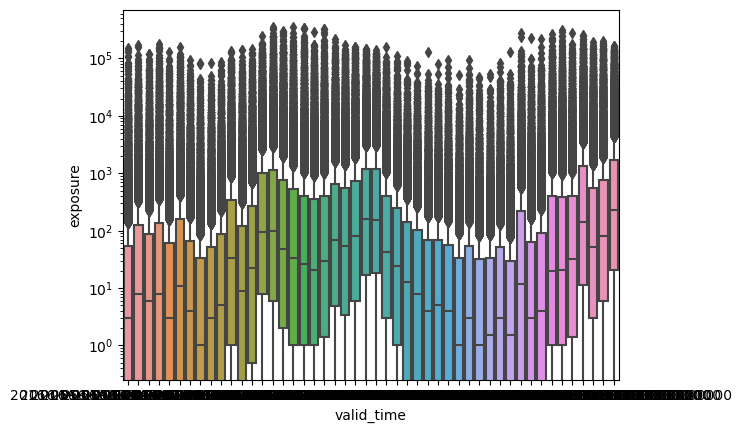

In [70]:
x, y, = 6, 6
g = sns.boxplot(data=df[(df['x'] == x) & (df['y'] == y)], x='valid_time', y='exposure')
g.set_yscale("log")

In [27]:
client.shutdown()

In [11]:
%%time
# compute various quantiles for the data groupd by gridcell and valid time
q_exposures_80km = {}
for q in [0.1, 0.5, 0.75, 0.9, 0.99, 0.999, 1]:
    q_exposures_80km[f"{q}"] = all_tracks_80km.groupby(['x','y', 'valid_time'])['exposure'].apply(np.quantile, q, meta=('float32')).compute()

CPU times: user 2min 45s, sys: 4.57 s, total: 2min 49s
Wall time: 3min 7s


In [16]:
q_exposures_80km["0.999"]

x   y   valid_time         
0   7   2016-05-11 21:00:00      416.450806
    15  2016-05-11 02:00:00       24.820000
    16  2016-05-11 18:00:00    25107.543000
    18  2016-05-10 02:00:00      303.246000
1   4   2016-05-10 01:00:00      702.644000
                                   ...     
36  15  2016-05-10 23:00:00      793.653212
    21  2016-05-11 14:00:00       48.392250
37  5   2016-05-11 07:00:00      730.166000
    10  2016-05-10 16:00:00     1246.813000
    11  2016-05-10 05:00:00       38.991000
Length: 45600, dtype: float64

In [28]:
%%time
# compute various quantiles for the data groupd by gridcell and valid time
q_exposures = {}
for q in [0.1, 0.5, 0.75, 0.9, 0.99, 0.999, 1]:
    q_exposures[f"{q}"] = all_tracks.groupby(['x','y', 'valid_time'])['exposure'].apply(np.quantile, q, meta=('float32')).compute()

CPU times: user 23.9 s, sys: 2.75 s, total: 26.7 s
Wall time: 3min 2s


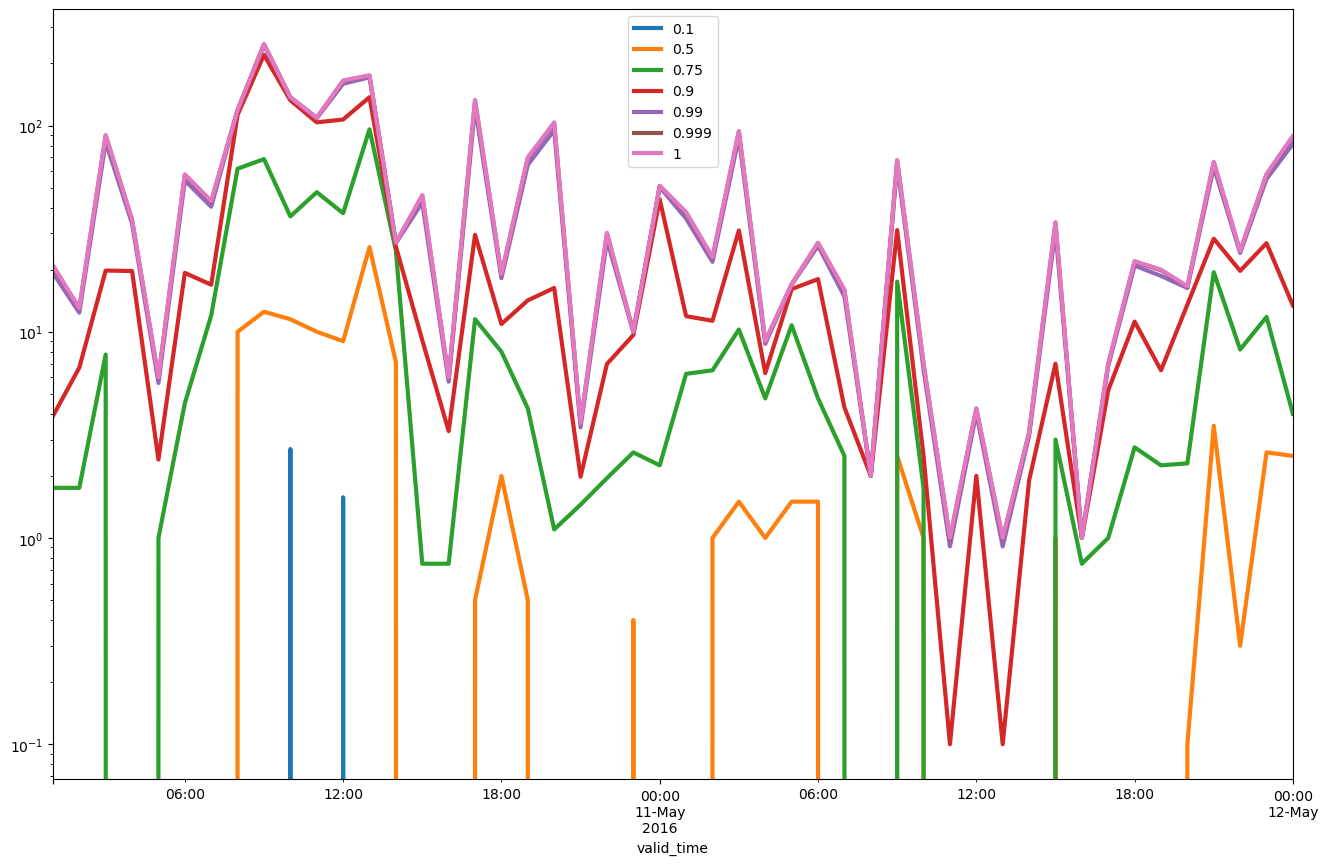

In [20]:
# plot the quantiles by time for a specific grid cell
x = 6
y = 6
plt.figure(figsize=(16, 10))
for q in [0.1, 0.5, 0.75, 0.9, 0.99, 0.999, 1]:
    q_exposures_80km[str(q)].loc[(x, y)].sort_index().plot(logy=True, linewidth=3, label=q)
plt.legend()

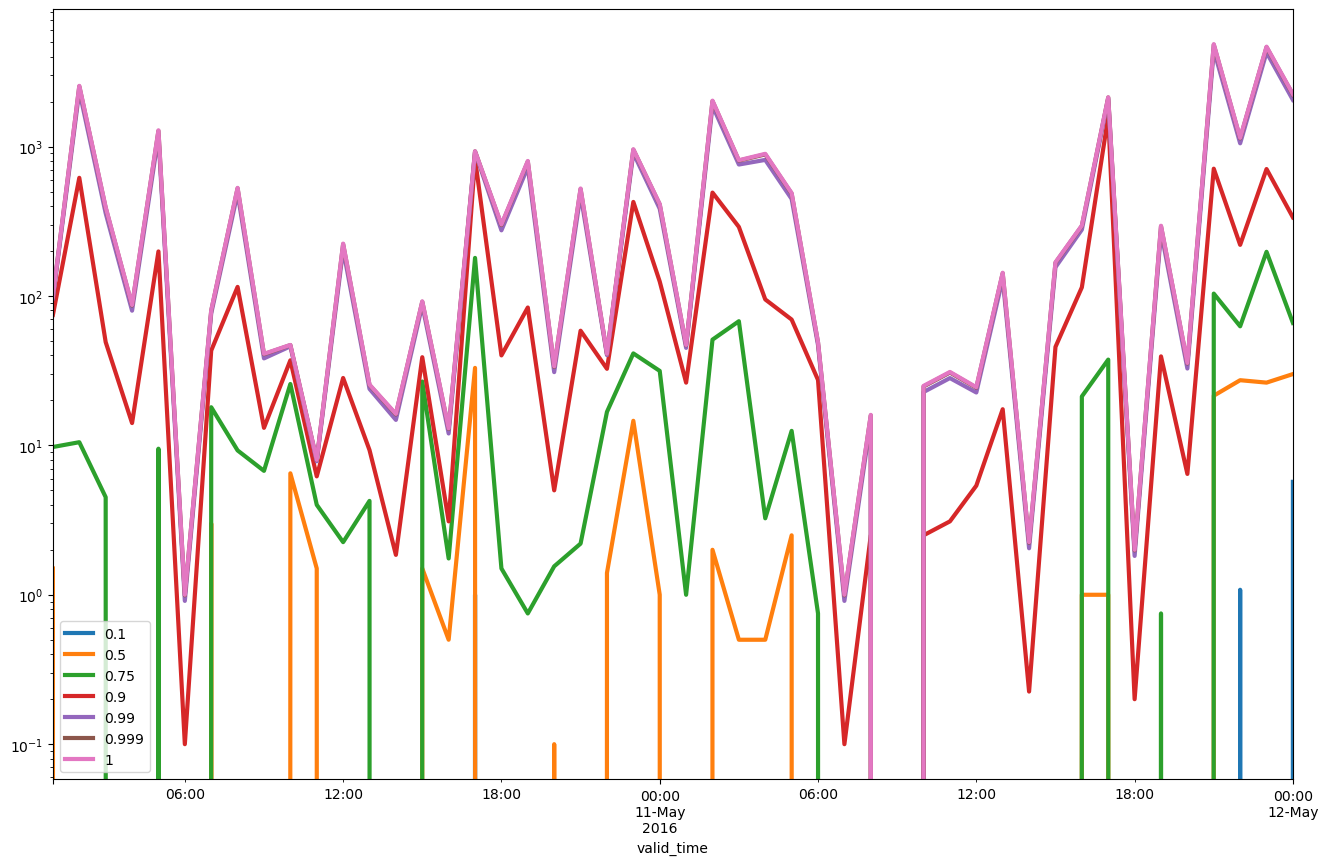

In [22]:
# plot the quantiles by time for a specific grid cell
x = 11
y = 21
plt.figure(figsize=(16, 10))
for q in [0.1, 0.5, 0.75, 0.9, 0.99, 0.999, 1]:
    q_exposures_80km[str(q)].loc[(x, y)].sort_index().plot(logy=True, linewidth=3, label=q)
plt.legend()

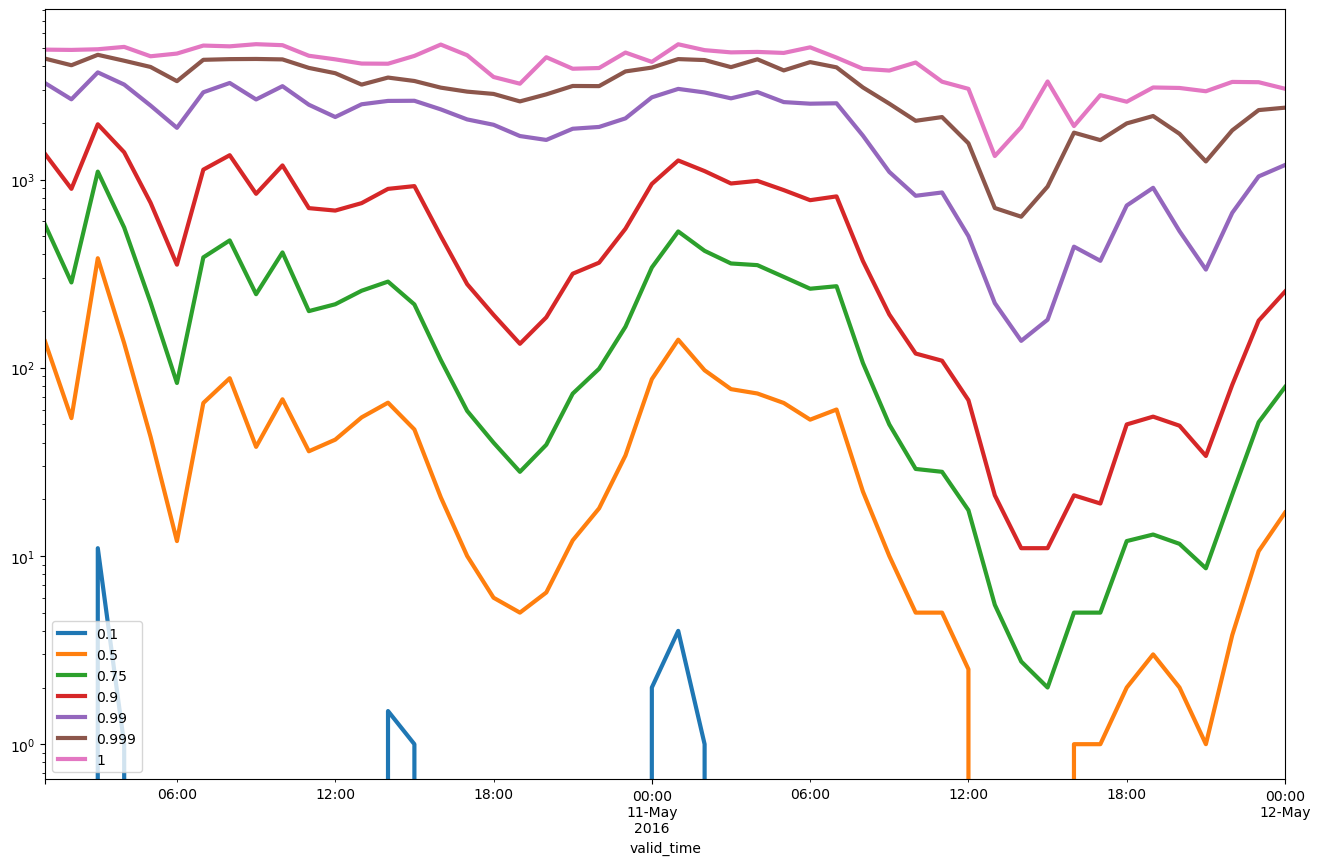

In [34]:
# plot the quantiles by time for a specific grid cell
x = 11
y = 21
plt.figure(figsize=(16, 10))
for q in [0.1, 0.5, 0.75, 0.9, 0.99, 0.999, 1]:
    q_exposures[str(q)].loc[(x, y)].sort_index().plot(logy=True, linewidth=3, label=q)
plt.legend()

/glade/scratch/cbecker/ipykernel_78383/3204632697.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  q_exposures[str(q)].loc[(x, y)].sort_index().plot(logy=True, linewidth=3, label=q)
/glade/work/cbecker/miniconda3/envs/risk/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:561: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()
/glade/scratch/cbecker/ipykernel_78383/3204632697.py:6: PerformanceWarning: indexing past lexsort depth may impact performance.
  q_exposures[str(q)].loc[(x, y)].sort_index().plot(logy=True, linewidth=3, label=q)
/glade/work/cbecker/miniconda3/envs/risk/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:561: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()
/glade/scratch/cbecker/ipykernel_78383/3204632697.py:6: Performa

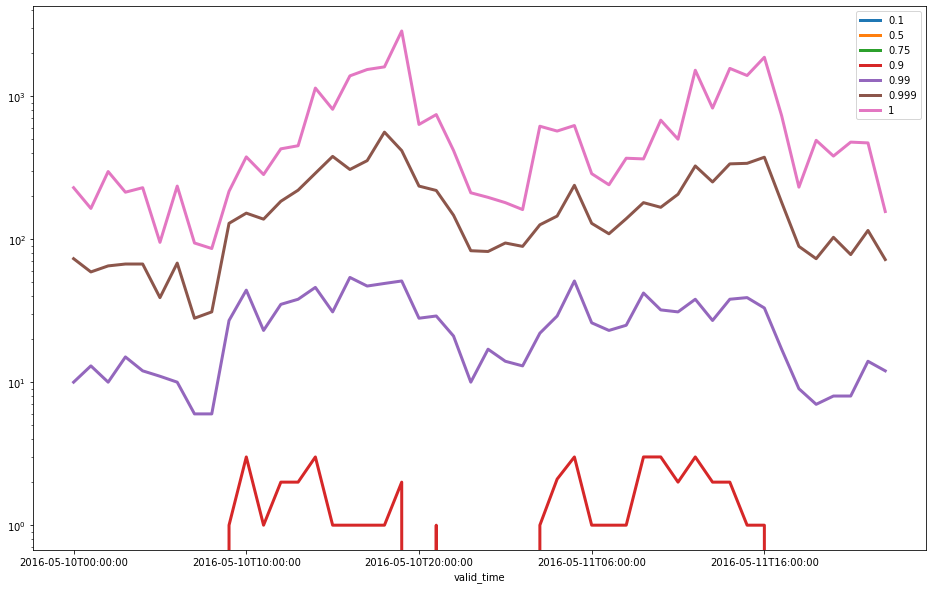

In [125]:
# # plot the quantiles by time for a specific grid cell
# x = 33
# y = 14
# plt.figure(figsize=(16, 10))
# for q in [0.1, 0.5, 0.75, 0.9, 0.99, 0.999, 1]:
#     q_exposures[str(q)].loc[(x, y)].sort_index().plot(logy=True, linewidth=3, label=q)
# plt.legend()